# Installs


In [ ]:
!sudo apt install graphviz
!pip install graphviz
!pip install hiddenlayer
!pip install torchinfo
!pip install torchmetrics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 20.6 MB/s eta 0:00:00


#Imports

In [ ]:
import os
import csv
import time
import random
import numpy as np
import torch
import torchvision.models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy, Precision, Recall, F1Score
from tqdm import tqdm
from torchinfo import summary
import torch.nn as nn
from torchvision import datasets, transforms
from tempfile import TemporaryDirectory
import hiddenlayer as hl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


# Loading Datasets From Previous Notebook

In [ ]:
# download original dataset
# create directory for dataset
!mkdir -p ./data

# download and unzip dataset
!wget -O ./data/plantvillage.zip https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded
!unzip ./data/plantvillage.zip -d ./data

# set dataset directory
data_dir = '/content/data/Plant_leave_diseases_dataset_without_augmentation'

# set random states
random_seed = 49
torch.manual_seed(random_seed)

# load entire dataset
dataset = datasets.ImageFolder(root=data_dir)

# load split indicies
train_indices = np.load('/content/test_indices.npy')
val_indices = np.load('/content/val_indices.npy')
test_indices = np.load('/content/test_indices.npy')

# apply transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_transformed_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_test_transformed_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)

# split datasets
train_subset = Subset(train_transformed_dataset, train_indices)
val_subset = Subset(val_test_transformed_dataset, val_indices)
test_subset = Subset(val_test_transformed_dataset, test_indices)


Streaming output truncated to the last 5000 lines.
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: ./data/Plant_leave_diseases_dataset_witho

# Loading Base Model

In [ ]:
base_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 90.6MB/s]


## Model Summary

In [ ]:
input_size = (1, 3, 224, 224) # example input size
summary(base_model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1000]                 --
├─Sequential: 1-1                        [1, 2208, 7, 7]           --
│    └─Conv2d: 2-1                       [1, 96, 112, 112]         14,112
│    └─BatchNorm2d: 2-2                  [1, 96, 112, 112]         192
│    └─ReLU: 2-3                         [1, 96, 112, 112]         --
│    └─MaxPool2d: 2-4                    [1, 96, 56, 56]           --
│    └─_DenseBlock: 2-5                  [1, 384, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [1, 48, 56, 56]           101,952
│    │    └─_DenseLayer: 3-2             [1, 48, 56, 56]           111,264
│    │    └─_DenseLayer: 3-3             [1, 48, 56, 56]           120,576
│    │    └─_DenseLayer: 3-4             [1, 48, 56, 56]           129,888
│    │    └─_DenseLayer: 3-5             [1, 48, 56, 56]           139,200
│    │    └─_DenseLayer: 3-6             [1, 48, 56, 56

# Training

## **Approach**
   **Feature Extraction + Linear Classifier**: we freeze all pretrained layers of the network except for the final linear layer. We will only train a simple linear classifier to match the classes in our dataset.


### Helper Classes and Functions

In [ ]:
class Callback:
    def on_train_begin(self, logs=None):
        pass

    def on_epoch_begin(self, epoch, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        pass

    def on_train_end(self, logs=None):
        pass

class EarlyStopping(Callback):
    def __init__(self, patience=5, min_delta=0.0, monitor='val_loss'):
        self.patience = patience
        self.min_delta = min_delta
        self.monitor = monitor
        self.best = -np.Inf if 'acc' in monitor else np.Inf
        self.wait = 0
        self.stopped_epoch = 0
        self.stop_training = False

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if ('acc' in self.monitor and current > self.best + self.min_delta) or \
           ('loss' in self.monitor and current < self.best - self.min_delta):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
                print(f"\nEarly stopping at epoch {epoch+1}")

class ReduceLROnPlateau(Callback):
    def __init__(self, optimizer, factor=0.1, patience=5, min_lr=1e-6, verbose=True, monitor='val_loss'):
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.monitor = monitor
        self.best = np.Inf if 'loss' in monitor else -np.Inf
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if ('loss' in self.monitor and current < self.best) or \
           ('acc' in self.monitor and current > self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self._reduce_lr()
                self.wait = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.factor, self.min_lr)
            if old_lr > new_lr:
                param_group['lr'] = new_lr
                if self.verbose:
                    print(f"\nreducing learning rate to {new_lr:.6f}.")

class MetricLogger(Callback):
    def __init__(self, device='cpu', num_classes=39):
        # initialize metrics for training
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
        self.train_precision = Precision(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
        self.train_recall = Recall(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
        self.train_f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)

        # initialize metrics for validation
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
        self.val_precision = Precision(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
        self.val_recall = Recall(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
        self.val_f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)

        # store logs
        self.logs = {
            'epoch': [],
            'train_loss': [],
            'train_acc': [],
            'train_precision': [],
            'train_recall': [],
            'train_f1_score': [],
            'val_loss': [],
            'val_acc': [],
            'val_precision': [],
            'val_recall': [],
            'val_f1_score': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # log training metrics
        self.logs['epoch'].append(epoch + 1)
        self.logs['train_loss'].append(logs.get('loss'))
        self.logs['train_acc'].append(self.train_accuracy.compute().item())
        self.logs['train_precision'].append(self.train_precision.compute().item())
        self.logs['train_recall'].append(self.train_recall.compute().item())
        self.logs['train_f1_score'].append(self.train_f1.compute().item())

        # reset training metrics
        self.train_accuracy.reset()
        self.train_precision.reset()
        self.train_recall.reset()
        self.train_f1.reset()

        # log validation metrics
        self.logs['val_loss'].append(logs.get('val_loss'))
        self.logs['val_acc'].append(self.val_accuracy.compute().item())
        self.logs['val_precision'].append(self.val_precision.compute().item())
        self.logs['val_recall'].append(self.val_recall.compute().item())
        self.logs['val_f1_score'].append(self.val_f1.compute().item())

        # reset validation metrics
        self.val_accuracy.reset()
        self.val_precision.reset()
        self.val_recall.reset()
        self.val_f1.reset()

    def get_logs(self):
        return self.logs

class CSVLogger(Callback):
    def __init__(self, filename):
        self.filename = filename
        self.file = open(self.filename, 'w', newline='')
        self.writer = None

    def on_train_begin(self, logs=None):
        self.writer = None

    def on_epoch_end(self, epoch, logs=None):
        if self.writer is None:
            headers = list(logs.keys())
            self.writer = csv.DictWriter(self.file, fieldnames=headers)
            self.writer.writeheader()
        self.writer.writerow(logs)
        self.file.flush()

    def on_train_end(self, logs=None):
        self.file.close()

class ModelCheckpoint(Callback):
    def __init__(self, save_dir, filename='checkpoint.pth', save_best_only=True, monitor='val_loss', mode='min'):
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.filename = filename
        self.save_best_only = save_best_only
        self.monitor = monitor
        self.mode = mode
        self.best = np.Inf if mode == 'min' else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return

        if self.save_best_only:
            if (self.mode == 'min' and current < self.best) or \
               (self.mode == 'max' and current > self.best):
                self.best = current
                self.save_checkpoint(epoch, logs)
        else:
            self.save_checkpoint(epoch, logs)

    def save_checkpoint(self, epoch, logs):
        checkpoint_path = os.path.join(self.save_dir, f'epoch_{epoch+1}_{self.filename}')
        torch.save({
            'epoch': epoch + 1,
            'state_dict': logs.get('model_state_dict'),
            'optimizer_state_dict': logs.get('optimizer_state_dict'),
            'logs': logs
        }, checkpoint_path)
        print(f"\ncheckpoint saved at {checkpoint_path}")

In [ ]:
# training function
def train_classifier(
    feature_extractor,
    classifier,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs=10,
    callbacks=None,
    checkpoint_dir='checkpoints'  # default checkpoint directory
):
    if callbacks is None:
        callbacks = []

    # instantiate ModelCheckpoint and add to callbacks
    model_checkpoint = ModelCheckpoint(
        save_dir=checkpoint_dir,
        filename='best_model.pth',
        save_best_only=True,
        monitor='val_loss',
        mode='min'
    )
    callbacks.append(model_checkpoint)

    # trigger callbacks 'on_train_begin'
    for callback in callbacks:
        callback.on_train_begin()

    since = time.time()
    feature_extractor.eval()  # feature extractor is frozen

    best_loss = float('inf')  # use infinity for better clarity

    try:
        for epoch in range(num_epochs):
            print(f'epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # trigger callbacks 'on_epoch_begin'
            for callback in callbacks:
                callback.on_epoch_begin(epoch)

            # training phase
            classifier.train()
            train_running_loss = 0.0
            train_running_corrects = 0

            # use tqdm for batch progress
            train_loader_tqdm = tqdm(train_loader, desc='training', leave=False)
            for inputs, labels in train_loader_tqdm:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass through feature extractor
                with torch.no_grad():
                    features = feature_extractor(inputs)
                    # features = features.view(features.size(0), -1)

                # forward pass through classifier
                outputs = classifier(features)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward pass and optimization
                loss.backward()
                optimizer.step()

                # statistics
                train_running_loss += loss.item() * inputs.size(0)
                train_running_corrects += torch.sum(preds == labels.data)

                # update metrics
                for callback in callbacks:
                    if isinstance(callback, MetricLogger):
                        callback.train_accuracy.update(preds, labels)
                        callback.train_precision.update(preds, labels)
                        callback.train_recall.update(preds, labels)
                        callback.train_f1.update(preds, labels)

            epoch_loss = train_running_loss / len(train_loader.dataset)
            epoch_acc = train_running_corrects.double() / len(train_loader.dataset)

            # validation phase
            classifier.eval()
            val_running_loss = 0.0
            val_running_corrects = 0

            with torch.no_grad():
                val_loader_tqdm = tqdm(val_loader, desc='validation', leave=False)
                for inputs, labels in val_loader_tqdm:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    features = feature_extractor(inputs)
                    # features = features.view(features.size(0), -1)

                    outputs = classifier(features)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    val_running_loss += loss.item() * inputs.size(0)
                    val_running_corrects += torch.sum(preds == labels.data)

                    # update metrics
                    for callback in callbacks:
                        if isinstance(callback, MetricLogger):
                            callback.val_accuracy.update(preds, labels)
                            callback.val_precision.update(preds, labels)
                            callback.val_recall.update(preds, labels)
                            callback.val_f1.update(preds, labels)

            val_loss = val_running_loss / len(val_loader.dataset)
            val_acc = val_running_corrects.double() / len(val_loader.dataset)

            logs = {
                'loss': epoch_loss,
                'acc': epoch_acc.item(),
                'val_loss': val_loss,
                'val_acc': val_acc.item(),
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }

            # trigger callbacks 'on_epoch_end'
            for callback in callbacks:
                callback.on_epoch_end(epoch, logs)

            # save best model based on validation loss
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(classifier.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
                print(f"\nbest model updated at epoch {epoch+1}")

            # check if any callback has set a flag to stop training
            if any(getattr(callback, 'stop_training', False) for callback in callbacks):
                print("stopping training.")
                break

    except KeyboardInterrupt:
        print("\ntraining interrupted manually. saving current model...")
        current_checkpoint_path = os.path.join(checkpoint_dir, f'interrupted_epoch_{epoch+1}.pth')
        torch.save(classifier.state_dict(), current_checkpoint_path)
        print(f"model saved at {current_checkpoint_path}")

    time_elapsed = time.time() - since
    print(f'training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'best val loss: {best_loss:.4f}')

    # load best model weights
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    if os.path.exists(best_model_path):
        classifier.load_state_dict(torch.load(best_model_path))
        print(f'best model loaded from {best_model_path}')
    else:
        print('best model not found. using the current model state.')

    # trigger callbacks 'on_train_end'
    for callback in callbacks:
        callback.on_train_end()

    return classifier

In [ ]:
# visualizing training logs
def visualize_logs(logs):
    metrics = {
        'loss': ('train_loss', 'val_loss'),
        'accuracy': ('train_acc', 'val_acc'),
        'precision': ('train_precision', 'val_precision'),
        'recall': ('train_recall', 'val_recall'),
        'f1_score': ('train_f1_score', 'val_f1_score')
    }

    num_metrics = len(metrics)


    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (metric_name, (train_key, val_key)) in enumerate(metrics.items()):
        ax = axes[idx]
        epochs = logs['epoch']

        ax.plot(epochs, logs[train_key], label='train', marker='o')
        ax.plot(epochs, logs[val_key], label='validation', marker='o')

        ax.set_title(f'{metric_name.capitalize()} over Epochs')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric_name.capitalize())

        ax.legend()

        ax.grid(True)

    if num_metrics < len(axes):
        axes[-1].axis('off')

    plt.tight_layout()
    plt.show()

# printing training logs
def print_training_metrics(logs):
    headers = [
        'Epoch', 'Train Loss', 'Val Loss',
        'Train Acc', 'Val Acc',
        'Train Precision', 'Val Precision',
        'Train Recall', 'Val Recall',
        'Train F1', 'Val F1'
    ]

    col_widths = [len(header) for header in headers]

    data_rows = []
    for i in range(len(logs['epoch'])):
        row = [
            str(logs['epoch'][i]),
            f"{logs['train_loss'][i]:.4f}",
            f"{logs['val_loss'][i]:.4f}",
            f"{logs['train_acc'][i]:.4f}",
            f"{logs['val_acc'][i]:.4f}",
            f"{logs['train_precision'][i]:.4f}",
            f"{logs['val_precision'][i]:.4f}",
            f"{logs['train_recall'][i]:.4f}",
            f"{logs['val_recall'][i]:.4f}",
            f"{logs['train_f1_score'][i]:.4f}",
            f"{logs['val_f1_score'][i]:.4f}"
        ]
        data_rows.append(row)
        for idx, item in enumerate(row):
            col_widths[idx] = max(col_widths[idx], len(item))

    header_fmt = " | ".join([f"{{:<{w}}}" for w in col_widths])
    row_fmt = " | ".join([f"{{:<{w}}}" for w in col_widths])

    print(header_fmt.format(*headers))
    print("-" * (sum(col_widths) + 3 * (len(headers) -1)))

    for row in data_rows:
        print(row_fmt.format(*row))

## Feature Extraction + Linear Classifier

To transform the DenseNet161 architecture to a feature extractor, we remove the last linear layer which acts as a classifier. However, we can't just directly place a linear classifier on top of it. The output dimensions from the layer before (BatchNorm2D) is of shape \[1, 2208, 7, 7\], when flattened that becomes a 108,192 dimension vector, training a model with that many input dimensions and 39 classes leads to over 4 million parameters, which makes it extremely computationally expensive and impractical.

Instead we first pass the output of the feature extractor through a ReLu layer, followed by a 2d average pooling layer with a kernel size of 7, this allows us to reduce the \[1, 2208, 7, 7\] output shape to a much more managable \[1, 2208\].

In [ ]:
# remove classifier layer from base model
feature_extractor = nn.Sequential(*list(base_model.children())[:-1])

# freeze all parameters in feature extractor layers
for param in feature_extractor.parameters():
    param.requires_grad = False

# define classifier
class LinearClassifier(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(LinearClassifier, self).__init__()
        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.fc = nn.Linear(input_channels, num_classes)

    def forward(self, x):
        x = self.relu(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

# instantiate
linear_classifier = LinearClassifier(base_model.classifier.in_features, len(dataset.classes))

# move to device
feature_extractor = feature_extractor.to(device)
linear_classifier = linear_classifier.to(device)

In [ ]:
# data loaders
batch_size = 512
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# training details
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_classifier.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=1, min_delta=0.001, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, min_lr=1e-6, monitor='val_loss')
metric_logger = MetricLogger(device=device, num_classes=len(dataset.classes))
csv_logger = CSVLogger('training_logs.csv')

# train classifier
trained_classifier = train_classifier(
    feature_extractor=feature_extractor,
    classifier=linear_classifier,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100,
    callbacks=[early_stopping, lr_scheduler, metric_logger, csv_logger]
)

epoch 1/100
----------



checkpoint saved at checkpoints/epoch_1_best_model.pth

best model updated at epoch 1
epoch 2/100
----------



checkpoint saved at checkpoints/epoch_2_best_model.pth

best model updated at epoch 2
epoch 3/100
----------



checkpoint saved at checkpoints/epoch_3_best_model.pth

best model updated at epoch 3
epoch 4/100
----------



checkpoint saved at checkpoints/epoch_4_best_model.pth

best model updated at epoch 4
epoch 5/100
----------



checkpoint saved at checkpoints/epoch_5_best_model.pth

best model updated at epoch 5
epoch 6/100
----------



checkpoint saved at checkpoints/epoch_6_best_model.pth

best model updated at epoch 6
epoch 7/100
----------



checkpoint saved at checkpoints/epoch_7_best_model.pth

best model updated at epoch 7
epoch 8/100
----------



checkpoint saved at checkpoints/epoch_8_best_model.pth

best model updated at epoch 8
epoch 9/100
----------



checkpoint saved at checkpoints/epoch_9_best_model.pth

best model updated at epoch 9
epoch 10/100
----------



checkpoint saved at checkpoints/epoch_10_best_model.pth

best model updated at epoch 10
epoch 11/100
----------



checkpoint saved at checkpoints/epoch_11_best_model.pth

best model updated at epoch 11
epoch 12/100
----------



checkpoint saved at checkpoints/epoch_12_best_model.pth

best model updated at epoch 12
epoch 13/100
----------



checkpoint saved at checkpoints/epoch_13_best_model.pth

best model updated at epoch 13
epoch 14/100
----------



checkpoint saved at checkpoints/epoch_14_best_model.pth

best model updated at epoch 14
epoch 15/100
----------



checkpoint saved at checkpoints/epoch_15_best_model.pth

best model updated at epoch 15
epoch 16/100
----------



checkpoint saved at checkpoints/epoch_16_best_model.pth

best model updated at epoch 16
epoch 17/100
----------



checkpoint saved at checkpoints/epoch_17_best_model.pth

best model updated at epoch 17
epoch 18/100
----------



checkpoint saved at checkpoints/epoch_18_best_model.pth

best model updated at epoch 18
epoch 19/100
----------



checkpoint saved at checkpoints/epoch_19_best_model.pth

best model updated at epoch 19
epoch 20/100
----------



checkpoint saved at checkpoints/epoch_20_best_model.pth

best model updated at epoch 20
epoch 21/100
----------



checkpoint saved at checkpoints/epoch_21_best_model.pth

best model updated at epoch 21
epoch 22/100
----------



checkpoint saved at checkpoints/epoch_22_best_model.pth

best model updated at epoch 22
epoch 23/100
----------



training interrupted manually. saving current model...
model saved at checkpoints/interrupted_epoch_23.pth
training complete in 61m 25s
best val loss: 0.2802
best model loaded from checkpoints/best_model.pth


<ipython-input-8-21f6cba5f13f>:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(best_model_path))


### Training Logs

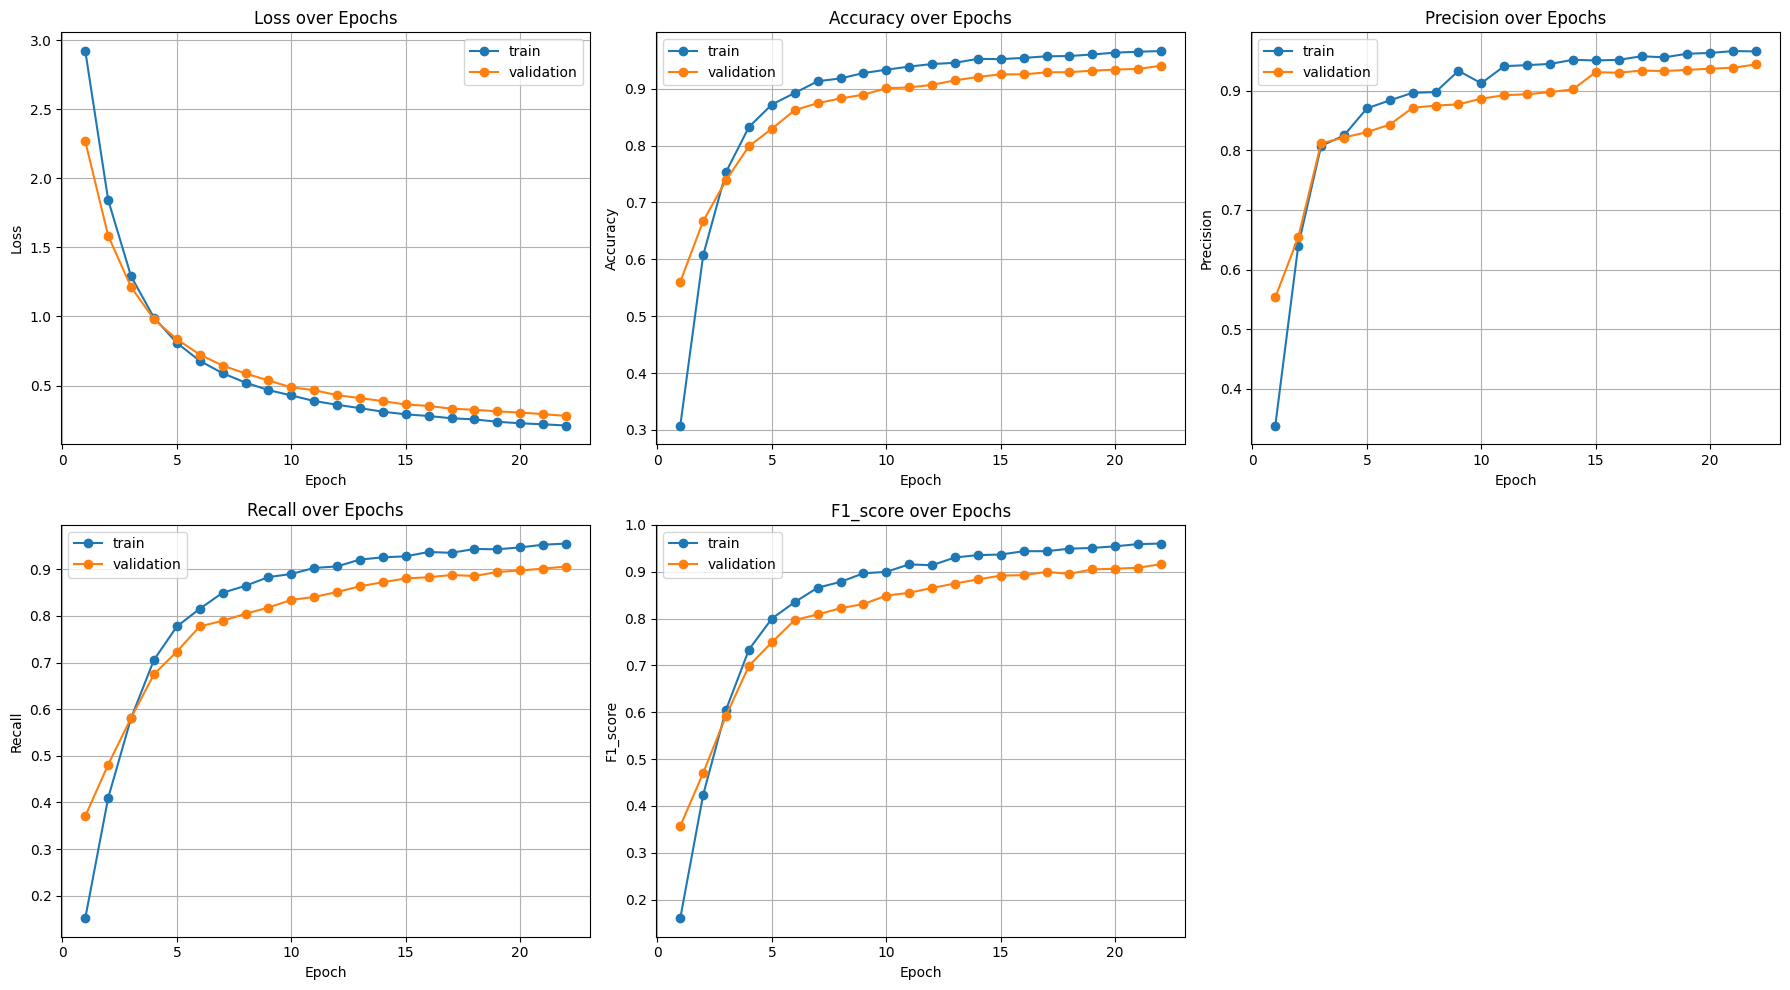

In [ ]:
training_logs = metric_logger.get_logs()
visualize_logs(training_logs)

In [ ]:
print_training_metrics(training_logs)

Epoch | Train Loss | Val Loss | Train Acc | Val Acc | Train Precision | Val Precision | Train Recall | Val Recall | Train F1 | Val F1
-------------------------------------------------------------------------------------------------------------------------------------
1     | 2.9201     | 2.2665   | 0.3078    | 0.5607  | 0.3380          | 0.5533        | 0.1519       | 0.3707     | 0.1608   | 0.3571
2     | 1.8417     | 1.5833   | 0.6074    | 0.6673  | 0.6395          | 0.6539        | 0.4098       | 0.4811     | 0.4241   | 0.4706
3     | 1.2900     | 1.2121   | 0.7538    | 0.7392  | 0.8076          | 0.8119        | 0.5809       | 0.5814     | 0.6057   | 0.5929
4     | 0.9907     | 0.9796   | 0.8329    | 0.7991  | 0.8251          | 0.8217        | 0.7059       | 0.6750     | 0.7340   | 0.6992
5     | 0.8083     | 0.8349   | 0.8723    | 0.8296  | 0.8706          | 0.8308        | 0.7774       | 0.7236     | 0.8000   | 0.7493
6     | 0.6789     | 0.7235   | 0.8926    | 0.8625  | 0.8841  

## Approach 2: Feature Extraction + MLP Classifier



# Evaluation

### Helper Functions

In [ ]:
def evaluate_model(model, feature_extractor, data_loader, criterion, device, num_classes, class_names, save_cm=False, save_path=None):
    model.eval()
    feature_extractor.eval()

    accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    precision = Precision(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
    recall = Recall(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)
    f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes, zero_division=0).to(device)

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass through feature extractor
            features = feature_extractor(inputs)
            # features = features.view(features.size(0), -1)  # Optional based on feature extractor output

            # forward pass through classifier
            outputs = model(features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # update metrics
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = accuracy.compute().item()
    epoch_precision = precision.compute().item()
    epoch_recall = recall.compute().item()
    epoch_f1 = f1.compute().item()

    metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision,
        'recall': epoch_recall,
        'f1_score': epoch_f1
    }

    print(f"test loss: {epoch_loss:.4f} | test acc: {epoch_acc:.4f} | test precision: {epoch_precision:.4f} | test recall: {epoch_recall:.4f} | test f1: {epoch_f1:.4f}")

    if save_cm and save_path is not None:
        cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
        # add a small constant to avoid log(0)
        cm_log = cm + 1

        plt.figure(figsize=(20, 16))
        im = plt.imshow(cm_log, interpolation='nearest', cmap=plt.cm.Blues, norm=LogNorm())
        plt.title('Confusion Matrix on Test Set (Log Scale)')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        tick_marks = range(num_classes)
        plt.xticks(tick_marks, tick_marks, rotation=90)  # using class numbers
        plt.yticks(tick_marks, tick_marks)

        # annotate cells with counts
        thresh = cm.max() / 2.
        for i in range(num_classes):
            for j in range(num_classes):
                # use cm[i, j] instead of cm_log for the text
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(save_path)
        plt.close()
        print(f"Confusion matrix saved at {save_path}")

    return metrics

def evaluate_checkpoints(checkpoint_dir, feature_extractor, classifier, test_loader, criterion, device, num_classes, class_names, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok=True)

    # list all checkpoint files and sort them based on epoch number
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

    # extract epoch numbers and sort checkpoints
    def extract_epoch(file_name):
        try:
            # filename format 'epoch_X_checkpoint.pth'
            parts = file_name.split('_')
            for part in parts:
                if part.isdigit():
                    return int(part)
            return 0  # default this will trigger for our best model
        except:
            return 0

    sorted_checkpoints = sorted(checkpoint_files, key=extract_epoch)

    for checkpoint_file in tqdm(sorted_checkpoints, desc="Evaluating Checkpoints"):
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        print(f"\nEvaluating checkpoint: {checkpoint_file}")

        # load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        classifier.load_state_dict(checkpoint['state_dict'])
        classifier.to(device)
        classifier.eval()

        # filename format 'epoch_X_checkpoint.pth'
        epoch_num = extract_epoch(checkpoint_file)
        cm_filename = f'confusion_matrix_epoch_{epoch_num}.png'
        cm_path = os.path.join(cm_save_dir, cm_filename)

        # evaluate and save confusion matrix
        evaluate_model(
            model=classifier,
            feature_extractor=feature_extractor,
            data_loader=test_loader,
            criterion=criterion,
            device=device,
            num_classes=num_classes,
            class_names=class_names,
            save_cm=True,
            save_path=cm_path
        )

def create_confusion_matrix_gif(cm_image_dir, gif_path, duration=1):
    images = []
    # sort images based on epoch number extracted from filename
    cm_files = sorted(
        [f for f in os.listdir(cm_image_dir) if f.endswith('.png')],
        key=lambda x: int(x.split('_')[3].split('.')[0])  # filename format 'confusion_matrix_epoch_X.png'
    )

    for cm_file in tqdm(cm_files, desc="Creating GIF"):
        cm_path = os.path.join(cm_image_dir, cm_file)
        images.append(imageio.imread(cm_path))

    # create and save GIF
    imageio.mimsave(gif_path, images, duration=duration)
    print(f"Confusion matrix GIF saved at {gif_path}")


def get_misclassifications(feature_extractor, classifier, data_loader: DataLoader, device, classifier_state_dict_path):
    # load classifier's state_dict
    classifier.load_state_dict(torch.load(classifier_state_dict_path, map_location=device))

    # set models to evaluation mode
    feature_extractor.eval()
    classifier.eval()

    # move models to device
    feature_extractor.to(device)
    classifier.to(device)

    misclassified_samples = []

    with torch.no_grad():
        # iterate through data_loader
        for batch_idx, (inputs, labels) in enumerate(tqdm(data_loader, desc="collecting misclassified samples")):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward pass through feature extractor
            features = feature_extractor(inputs)
            # features = features.view(features.size(0), -1)  # uncomment if needed based on feature extractor output

            # forward pass through classifier
            outputs = classifier(features)

            # get predictions
            _, preds = torch.max(outputs, 1)

            # find indices where prediction != label
            mis_mask = preds != labels
            mis_indices = torch.nonzero(mis_mask).squeeze()

            if mis_indices.numel() == 0:
                continue

            if mis_indices.dim() == 0:
                mis_indices = mis_indices.unsqueeze(0)

            # calculate the dataset index assuming no shuffling
            dataset_start_idx = batch_idx * data_loader.batch_size
            for idx in mis_indices.cpu().numpy():
                dataset_idx = dataset_start_idx + idx
                if dataset_idx >= len(data_loader.dataset):
                    continue  # skip if index exceeds dataset size

                img, true_label = data_loader.dataset[dataset_idx]
                pred_label = preds[idx].cpu().item()
                misclassified_samples.append((img, true_label, pred_label))

    print(f"total misclassified samples: {len(misclassified_samples)}")
    return misclassified_samples

def visualize_misclassifications(misclassified_samples, data_loader: DataLoader, class_names, num_samples=3, seed=42):
    if len(misclassified_samples) == 0:
        print("No misclassified samples to visualize.")
        return

    # ensure reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # randomly select misclassified samples
    selected_misclassified = random.sample(misclassified_samples, min(num_samples, len(misclassified_samples)))

    # precompute a mapping from class labels to dataset indices for contextual examples
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx in tqdm(range(len(data_loader.dataset)), desc="Mapping classes to dataset indices"):
        _, label = data_loader.dataset[idx]
        class_to_indices[label].append(idx)

    # prepare contextual examples
    contextual_examples = []
    for img, true_label, pred_label in selected_misclassified:
        # get 3 random correct examples
        true_indices = class_to_indices[true_label]
        if len(true_indices) >= 3:
            true_sample_indices = random.sample(true_indices, 3)
        else:
            true_sample_indices = random.choices(true_indices, k=3)  # with replacement if not enough

        true_samples = [data_loader.dataset[idx][0] for idx in true_sample_indices]

        # get 3 random predicted class examples
        pred_indices = class_to_indices[pred_label]
        if len(pred_indices) >= 3:
            pred_sample_indices = random.sample(pred_indices, 3)
        else:
            pred_sample_indices = random.choices(pred_indices, k=3)

        pred_samples = [data_loader.dataset[idx][0] for idx in pred_sample_indices]

        contextual_examples.append((true_samples, pred_samples))

    # plotting
    fig = plt.figure(figsize=(20, 5 * num_samples))
    main_gs = fig.add_gridspec(nrows=num_samples, ncols=2, width_ratios=[2, 6], wspace=0.4, hspace=0.4)

    for i in range(num_samples):
        # plot misclassified image on the left
        ax_mis = fig.add_subplot(main_gs[i, 0])
        img_mis = prepare_image_for_plotting(selected_misclassified[i][0])
        ax_mis.imshow(img_mis)
        ax_mis.axis('off')
        ax_mis.set_title(f"Misclassified\nPred: {class_names[selected_misclassified[i][2]]}\nTrue: {class_names[selected_misclassified[i][1]]}", fontsize=12)

        # create a nested gridspec for contextual examples on the right
        context_gs = main_gs[i, 1].subgridspec(nrows=2, ncols=3, wspace=0.1, hspace=0.3)

        # plot true class examples (top row)
        for j in range(3):
            ax_true = fig.add_subplot(context_gs[0, j])
            img_true = prepare_image_for_plotting(contextual_examples[i][0][j])
            ax_true.imshow(img_true)
            ax_true.axis('off')
            if j == 1:
                ax_true.set_title(f"True Class: {class_names[selected_misclassified[i][1]]}", fontsize=12)

        # plot predicted class examples (bottom row)
        for j in range(3):
            ax_pred = fig.add_subplot(context_gs[1, j])
            img_pred = prepare_image_for_plotting(contextual_examples[i][1][j])
            ax_pred.imshow(img_pred)
            ax_pred.axis('off')
            if j == 1:
                ax_pred.set_title(f"Predicted Class: {class_names[selected_misclassified[i][2]]}", fontsize=12)

    plt.suptitle('Misclassified Sample', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def prepare_image_for_plotting(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    if isinstance(img, torch.Tensor):
        img = img.cpu().clone()
        # unnormalize
        img = img.numpy().transpose(1, 2, 0)
        img = (img * std) + mean
    elif isinstance(img, np.ndarray):
        if img.ndim == 3 and img.shape[0] in [1, 3]:
            if img.shape[0] == 1:
                img = img.squeeze(0)
                img = np.stack([img]*3, axis=-1)
            else:
                img = np.transpose(img, (1, 2, 0))
    else:
        raise TypeError("Unsupported image type. Must be a torch.Tensor or np.ndarray.")

    # ensure the image is in [0,1]
    img = np.clip(img, 0, 1)

    return img

## Approach 1: Feature Extraction + Linear Classifier

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# data loader
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# evaluate each checkpoint on the test set and save their confusion matrices
evaluate_checkpoints(
    checkpoint_dir='checkpoints',
    feature_extractor=feature_extractor,
    classifier=linear_classifier,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=len(dataset.classes),
    class_names=dataset.classes,
    cm_save_dir='confusion_matrices/checkpoints'
)

Evaluating Checkpoints:   0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(check


Evaluating checkpoint: epoch_1_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:21<00:00,  3.81s/it]
                                                           

test loss: 2.2581 | test acc: 0.5601 | test precision: 0.5677 | test recall: 0.3696 | test f1: 0.3577


Evaluating Checkpoints:   5%|▍         | 1/21 [01:25<28:37, 85.88s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_1.png

Evaluating checkpoint: epoch_2_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:24<00:00,  4.08s/it]
                                                           

test loss: 1.5652 | test acc: 0.6708 | test precision: 0.6727 | test recall: 0.4842 | test f1: 0.4720


Evaluating Checkpoints:  10%|▉         | 2/21 [02:54<27:37, 87.26s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_2.png

Evaluating checkpoint: epoch_3_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.14s/it]
                                                           

test loss: 1.1854 | test acc: 0.7503 | test precision: 0.7961 | test recall: 0.5963 | test f1: 0.6089


Evaluating Checkpoints:  14%|█▍        | 3/21 [04:25<26:41, 88.97s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_3.png

Evaluating checkpoint: epoch_4_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.15s/it]
                                                           

test loss: 0.9463 | test acc: 0.8185 | test precision: 0.8418 | test recall: 0.6993 | test f1: 0.7238


Evaluating Checkpoints:  19%|█▉        | 4/21 [05:55<25:24, 89.69s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_4.png

Evaluating checkpoint: epoch_6_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.18s/it]
                                                           

test loss: 0.6821 | test acc: 0.8818 | test precision: 0.8861 | test recall: 0.7965 | test f1: 0.8157


Evaluating Checkpoints:  24%|██▍       | 5/21 [07:28<24:09, 90.58s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_6.png

Evaluating checkpoint: epoch_7_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:25<00:00,  4.08s/it]
                                                           

test loss: 0.6002 | test acc: 0.8934 | test precision: 0.8890 | test recall: 0.8123 | test f1: 0.8311


Evaluating Checkpoints:  29%|██▊       | 6/21 [08:57<22:35, 90.36s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_7.png

Evaluating checkpoint: epoch_8_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:26<00:00,  4.10s/it]
                                                           

test loss: 0.5409 | test acc: 0.9015 | test precision: 0.8935 | test recall: 0.8241 | test f1: 0.8411


Evaluating Checkpoints:  33%|███▎      | 7/21 [10:28<21:04, 90.36s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_8.png

Evaluating checkpoint: epoch_9_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.14s/it]
                                                           

test loss: 0.4890 | test acc: 0.9101 | test precision: 0.9241 | test recall: 0.8435 | test f1: 0.8586


Evaluating Checkpoints:  38%|███▊      | 8/21 [12:00<19:41, 90.90s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_9.png

Evaluating checkpoint: epoch_10_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:26<00:00,  4.11s/it]
                                                           

test loss: 0.4384 | test acc: 0.9250 | test precision: 0.9372 | test recall: 0.8676 | test f1: 0.8866


Evaluating Checkpoints:  43%|████▎     | 9/21 [13:30<18:09, 90.78s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_10.png

Evaluating checkpoint: epoch_11_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.13s/it]
                                                           

test loss: 0.4159 | test acc: 0.9275 | test precision: 0.9391 | test recall: 0.8773 | test f1: 0.8929


Evaluating Checkpoints:  48%|████▊     | 10/21 [15:02<16:40, 90.95s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_11.png

Evaluating checkpoint: epoch_12_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.16s/it]
                                                           

test loss: 0.3790 | test acc: 0.9304 | test precision: 0.9412 | test recall: 0.8899 | test f1: 0.9058


Evaluating Checkpoints:  52%|█████▏    | 11/21 [16:34<15:13, 91.33s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_12.png

Evaluating checkpoint: epoch_13_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.15s/it]
                                                           

test loss: 0.3579 | test acc: 0.9353 | test precision: 0.9443 | test recall: 0.8997 | test f1: 0.9151


Evaluating Checkpoints:  57%|█████▋    | 12/21 [18:06<13:43, 91.46s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_13.png

Evaluating checkpoint: epoch_14_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.15s/it]
                                                           

test loss: 0.3345 | test acc: 0.9407 | test precision: 0.9474 | test recall: 0.9092 | test f1: 0.9231


Evaluating Checkpoints:  62%|██████▏   | 13/21 [19:38<12:13, 91.65s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_14.png

Evaluating checkpoint: epoch_15_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.23s/it]
                                                           

test loss: 0.3104 | test acc: 0.9452 | test precision: 0.9493 | test recall: 0.9160 | test f1: 0.9292


Evaluating Checkpoints:  67%|██████▋   | 14/21 [21:10<10:43, 91.95s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_15.png

Evaluating checkpoint: epoch_16_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.19s/it]
                                                           

test loss: 0.2975 | test acc: 0.9466 | test precision: 0.9502 | test recall: 0.9220 | test f1: 0.9330


Evaluating Checkpoints:  71%|███████▏  | 15/21 [22:43<09:13, 92.20s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_16.png

Evaluating checkpoint: epoch_17_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.12s/it]
                                                           

test loss: 0.2789 | test acc: 0.9496 | test precision: 0.9546 | test recall: 0.9290 | test f1: 0.9389


Evaluating Checkpoints:  76%|███████▌  | 16/21 [24:15<07:40, 92.02s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_17.png

Evaluating checkpoint: epoch_18_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.21s/it]
                                                           

test loss: 0.2698 | test acc: 0.9514 | test precision: 0.9581 | test recall: 0.9260 | test f1: 0.9378


Evaluating Checkpoints:  81%|████████  | 17/21 [25:46<06:07, 91.90s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_18.png

Evaluating checkpoint: epoch_19_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.16s/it]
                                                           

test loss: 0.2579 | test acc: 0.9543 | test precision: 0.9587 | test recall: 0.9389 | test f1: 0.9472


Evaluating Checkpoints:  86%|████████▌ | 18/21 [27:18<04:35, 91.74s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_19.png

Evaluating checkpoint: epoch_20_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.16s/it]
                                                           

test loss: 0.2488 | test acc: 0.9565 | test precision: 0.9592 | test recall: 0.9396 | test f1: 0.9478


Evaluating Checkpoints:  90%|█████████ | 19/21 [28:50<03:03, 91.86s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_20.png

Evaluating checkpoint: epoch_21_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:27<00:00,  4.15s/it]
                                                           

test loss: 0.2365 | test acc: 0.9582 | test precision: 0.9596 | test recall: 0.9407 | test f1: 0.9480


Evaluating Checkpoints:  95%|█████████▌| 20/21 [30:21<01:31, 91.53s/it]<ipython-input-8-3e551038d33c>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.l

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_21.png

Evaluating checkpoint: epoch_22_best_model.pth



Evaluating: 100%|██████████| 17/17 [01:28<00:00,  4.15s/it]
                                                           

test loss: 0.2240 | test acc: 0.9608 | test precision: 0.9631 | test recall: 0.9444 | test f1: 0.9525


Evaluating Checkpoints: 100%|██████████| 21/21 [31:52<00:00, 91.08s/it]

Confusion matrix saved at confusion_matrices/checkpoints/confusion_matrix_epoch_22.png


In [ ]:
# create a GIF from the confusion matrix images of checkpoints
gif_output_path = 'confusion_matrices/confusion_matrix_evolution.gif'
create_confusion_matrix_gif(
    cm_image_dir='confusion_matrices/checkpoints',
    gif_path=gif_output_path,
    duration=2
)

Creating GIF:   0%|          | 0/21 [00:00<?, ?it/s]<ipython-input-8-3e551038d33c>:152: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(cm_path))
Creating GIF: 100%|██████████| 21/21 [00:01<00:00, 18.78it/s]


Confusion matrix GIF saved at confusion_matrices/confusion_matrix_evolution.gif


## Visualizing Misclassifications

In [ ]:
class_names = dataset.classes

In [ ]:
misclassified_samples = get_misclassifications(
    feature_extractor=feature_extractor,
    classifier=linear_classifier,
    data_loader=test_loader,
    device=device,
    classifier_state_dict_path='/content/best_model.pth'
)

<ipython-input-14-0f64984b0026>:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_state_dict_path, map_location=device))
co

total misclassified samples: 326


Mapping classes to dataset indices: 100%|██████████| 8318/8318 [00:19<00:00, 426.50it/s]
<ipython-input-22-108b6c408be4>:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


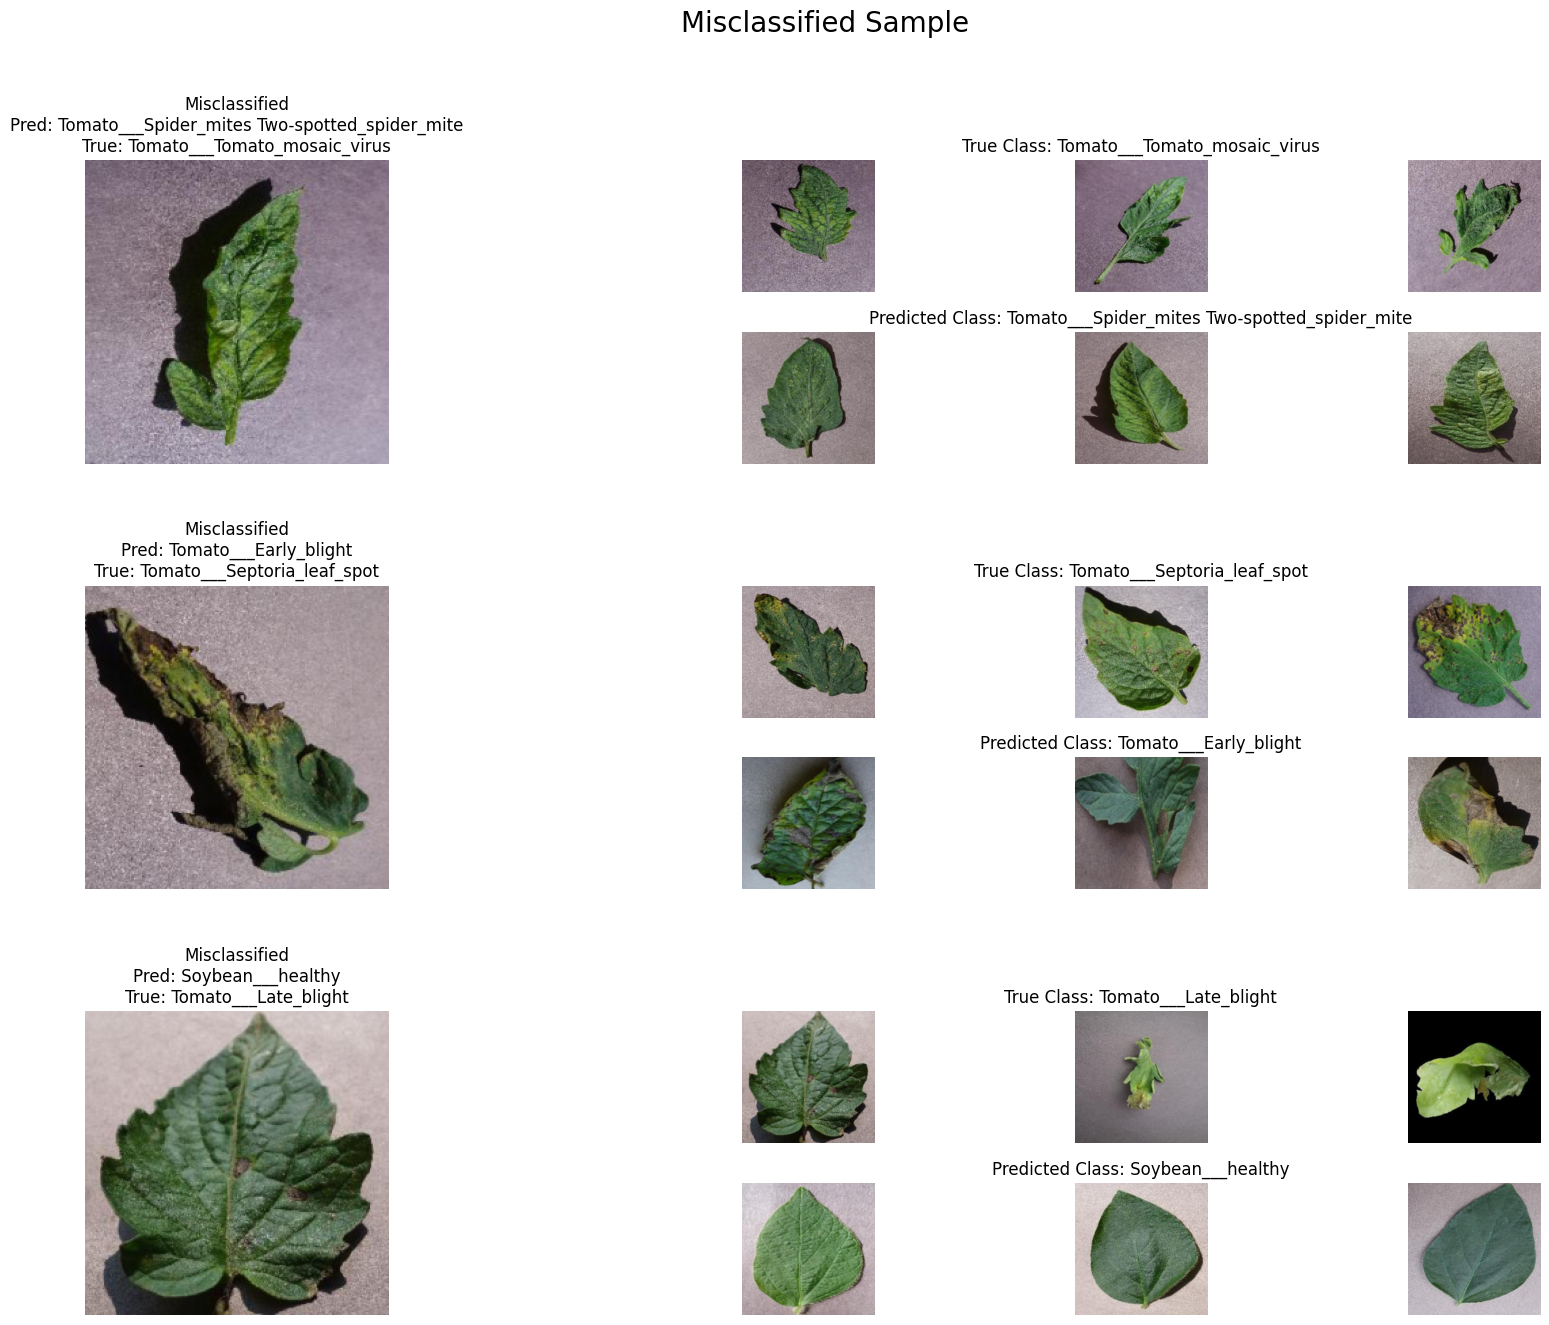

In [ ]:
visualize_misclassifications(
    misclassified_samples=misclassified_samples,
    data_loader=test_loader,
    class_names=class_names,
    num_samples=3,
    seed=17
)